# Assignment

In [18]:
%matplotlib inline
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import zipfile
import random

import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer


## Data

In [6]:
# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

file_path = './data/text8.zip'
vocabulary = read_data(file_path)
print('Data size', len(vocabulary))

Data size 17005207


In [7]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [8]:
vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

In [15]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

## Word2Vec Model

In [16]:
## some training settings
training_steps = 80000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

In [21]:
class Word2Vec(Model):
    def __init__(self):
        '''To-Do: Define model variables'''
        super(Word2Vec, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, center_words, target_words):
        '''To-Do: Define data flow and return loss'''
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

In [33]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)
    

@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec(center_words, target_words)
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

### Train Model

In [34]:
word2vec = Word2Vec()
dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print (template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.35
Step 4000, Loss: 31.97
Step 6000, Loss: 15.41
Step 8000, Loss: 10.79
Step 10000, Loss: 9.64
Step 12000, Loss: 8.74
Step 14000, Loss: 8.14
Step 16000, Loss: 7.47
Step 18000, Loss: 7.17
Step 20000, Loss: 6.99
Step 22000, Loss: 6.91
Step 24000, Loss: 6.75
Step 26000, Loss: 6.54
Step 28000, Loss: 6.43
Step 30000, Loss: 6.43
Step 32000, Loss: 6.39
Step 34000, Loss: 6.26
Step 36000, Loss: 6.25
Step 38000, Loss: 6.15
Step 40000, Loss: 6.14
Step 42000, Loss: 6.13
Step 44000, Loss: 5.95
Step 46000, Loss: 5.96
Step 48000, Loss: 5.99
Step 50000, Loss: 5.90
Step 52000, Loss: 5.89
Step 54000, Loss: 5.94
Step 56000, Loss: 5.89
Step 58000, Loss: 5.85
Step 60000, Loss: 5.93
Step 62000, Loss: 5.82
Step 64000, Loss: 5.82
Step 66000, Loss: 5.88
Step 68000, Loss: 5.80
Step 70000, Loss: 5.76
Step 72000, Loss: 5.85
Step 74000, Loss: 5.78
Step 76000, Loss: 5.45
Step 78000, Loss: 5.61
Step 80000, Loss: 5.71


### Learning Curve

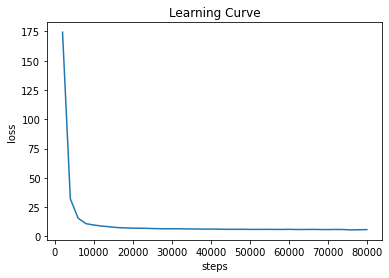

In [35]:
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

## Visualizing Embedding Matrix by t-SNE

In [36]:
embedding_matrix = word2vec.weights[0]

In [37]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

C:\Users\Che\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


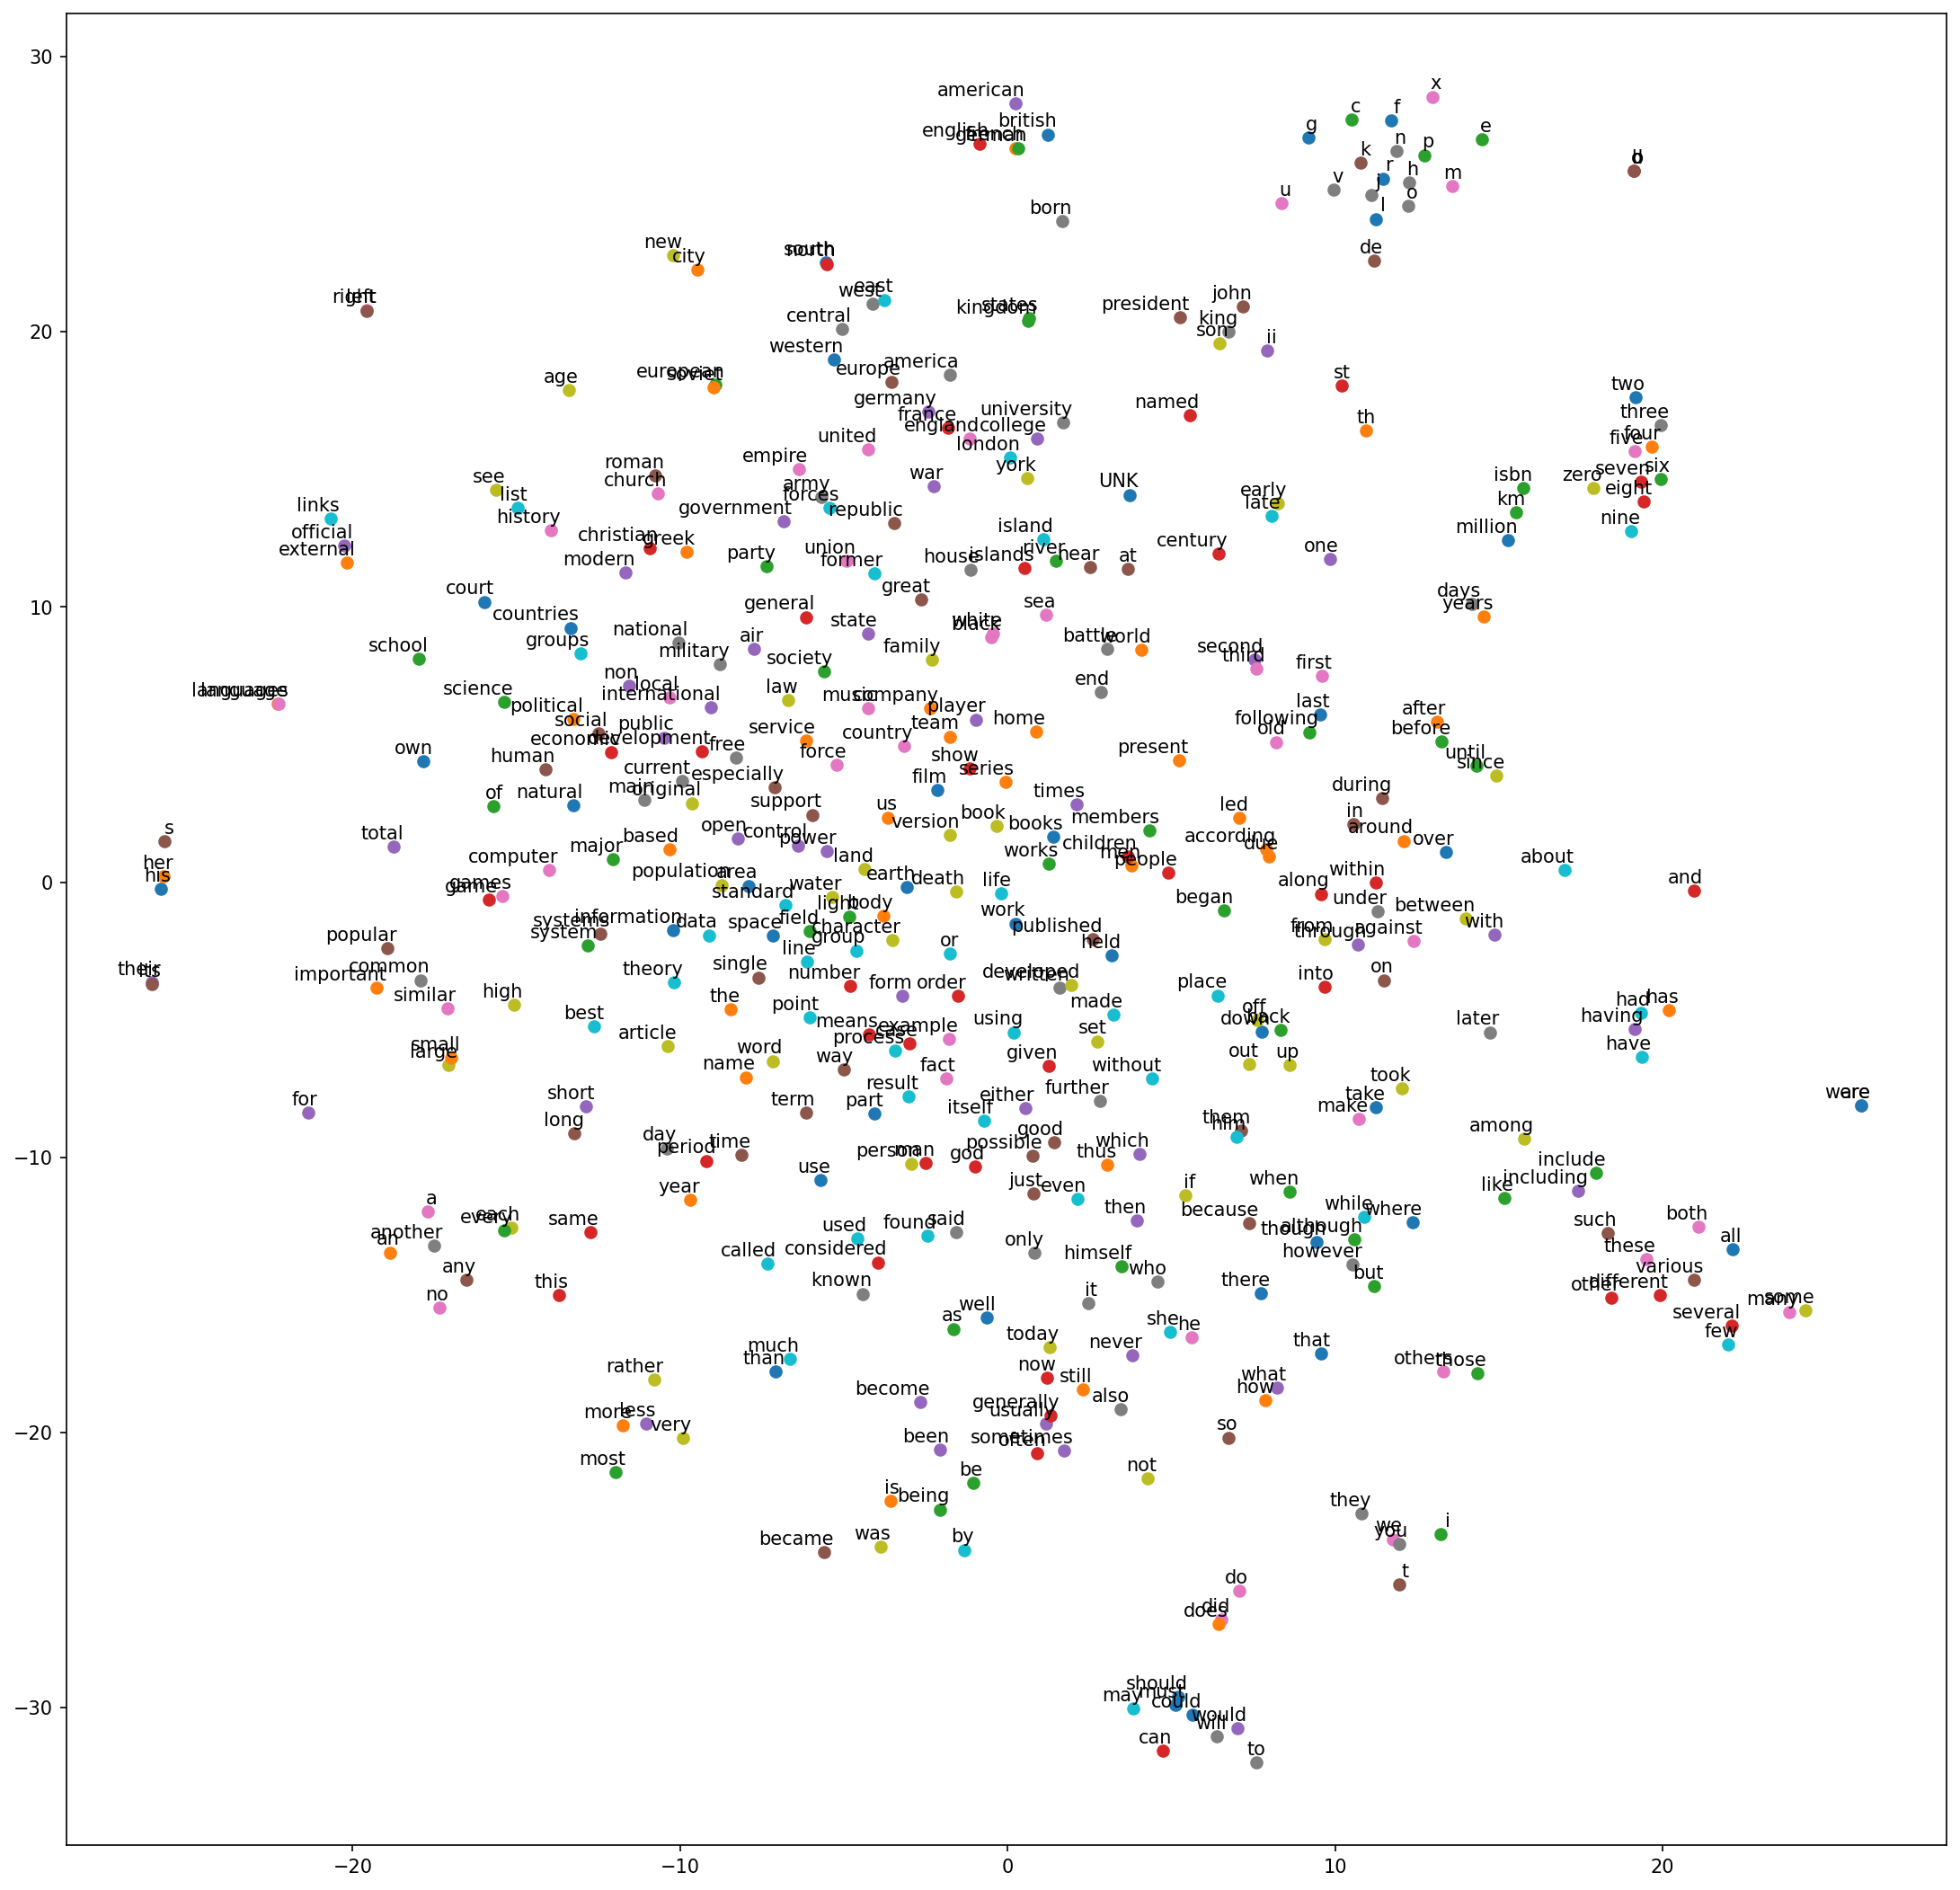

In [38]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Top-5 Nearest Neighbors

In [39]:
def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print('\n')

In [40]:
top_k_nearest('popular', 5)
top_k_nearest('have', 5)

---top 5 nearest words of popular---
popular
successful
folk
prominent
powerful


---top 5 nearest words of have---
have
having
had
has
previously




## Reference
<pre><code>
<b>Custom model:</b> https://www.tensorflow.org/guide/keras/custom_layers_and_models
</code></pre>